In [21]:
import requests
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import nltk
import string
import seaborn as sns
sns.set_style("dark")

# To set your environment variables in your terminal run the following line:
# export 'BEARER_TOKEN'='<your_bearer_token>'
# bearer_token = os.environ.get("BEARER_TOKEN")
bearer_token ='AAAAAAAAAAAAAAAAAAAAACqHUgEAAAAAcghJSkKBmFmw36ZiRxrqVdyomIk%3DZlDqMjNA0ka4btIuhDjiHUyRGoCHDzKBWvNGcqYXpLJ5kuhUAp'

In [22]:
def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

def connect_to_endpoint(url, params):
    response = requests.get(url, auth=bearer_oauth, params=params)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

# 1. Collecting data: 
In this assignment you need to collect data related to stock market from Twitter for one week. In Twitter, ticker symbols like #gold are used for stocks and companies. You are requested to collect the tweets with some specific keywords and store them in different files. The following keywords should be used:  
* Altcoin  
* Bitcoin  
* Coindesk  
* Cryptocurrency  
* Gold  
* APPL  
* GOOG  
* YHOO

Each tweet is a json file with the following format:  
```
{"created_at":”..........”,  
"id":”...........”,  
"text":" Time to buy some ether!\n#ethereum #investing #cryptocurrency”  
“user_id”:”...........”  
...  
}
```

In [47]:
dates = [
    # datetime.datetime(2021,10,16, 1),
    datetime.datetime(2021,10,17),
    datetime.datetime(2021,10,18),
    datetime.datetime(2021,10,19),
    datetime.datetime(2021,10,20),
    datetime.datetime(2021,10,21),
    datetime.datetime(2021,10,22),
]
keywords = ['altcoin', 'bitcoin', 'coindesk', 'cryptocurrency', 'gold', 'APPL', 'GOOG', 'YHOO']

In [48]:
class Scrapper:
    def __init__(self, keyword):
        self.keyword = keyword
        # Creates the dataframe for the keyword
        self.dataframe = pd.DataFrame()
    
    def file_name(self):
        return f'data/tweets_{self.keyword}.csv'

    def check_file_existence(self):
        return os.path.exists(self.file_name())
    
    def get_tweets(self, from_date):
        from_date_time = datetime.datetime(from_date.year, from_date.month, from_date.day, 10)
        to_date = datetime.datetime(from_date.year, from_date.month, from_date.day, 16)
        search_url = "https://api.twitter.com/2/tweets/search/recent"
        next_token = None
        # Tries to get 5 batches of 100 records
        for i in range(6):
            query_params = {
                'query': self.keyword, 
                'start_time': from_date_time.isoformat("T") + "Z", 
                'end_time': to_date.isoformat("T") + "Z",
                'tweet.fields': 'author_id,created_at', 
                'user.fields': 'location',
                'expansions': 'geo.place_id',
                'place.fields': 'country',
                'max_results': 100,
                'next_token': next_token
            }
            print(f'Querying keyword: "{self.keyword}", date: "{from_date}", asking for a batch of 100 tweets from API...')
            # Queries Twitter to get the keyword related tweets
            json_response = connect_to_endpoint(search_url, query_params)
            # Convert the response to a dataframe
            df = pd.DataFrame(json_response['data']) 
            df['Keyword'] = self.keyword
            # Appends the results to the planned day dataframe
            self.dataframe = self.dataframe.append(df, ignore_index=True)
            next_token = json_response['meta'].get('next_token', None)
            if next_token == None:
                break
       
    def save(self):
        print(f'Saving {self.file_name()}')
        self.dataframe.to_csv(self.file_name())
        
    def load(self):
        print(f'Loading {self.file_name()}')
        self.dataframe = pd.read_csv(self.file_name())
    

# 2. Saving data: 
You need to save the requested data into csv format of 8 files where data related to each keyword is saved. Each file consist of four columns: 
* tweet id
* time of tweet
* user id
* text.

In [49]:
# Executes the planned queries for each keyword
for keyword in keywords:
    scrapper = Scrapper(keyword)
    if scrapper.check_file_existence():
        # If the file already exists ommits the query to twitter API
        print(f'File {scrapper.file_name()} already exists.. skipping query to twitter API')
        continue
    # Gets tweet for each date
    for date in dates:
        scrapper.get_tweets(date)
    # Saves the file
    scrapper.save()       
        

Querying keyword: "altcoin", date: "2021-10-17 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2021-10-17 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2021-10-17 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2021-10-17 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2021-10-17 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2021-10-17 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2021-10-18 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2021-10-18 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2021-10-18 00:00:00", asking for a batch of 100 tweets from API...
200
Querying keyword: "altcoin", date: "2

# 3. Cleaning data: 
remove duplication, remove punctuations, remove numbers in tweets, and remove words with length less than 2.

In [50]:
# Reads the tweets csv files and consolidates them in a single dataframe
complete_df = pd.DataFrame() 
for keyword in keywords:
    scrapper = Scrapper(keyword)
    # Loads the data from its corresponding CSV file
    scrapper.load()
    # Merges the data in a single dataframe
    complete_df = complete_df.append(scrapper.dataframe, ignore_index=True)

Loading data/tweets_altcoin.csv
Loading data/tweets_bitcoin.csv
Loading data/tweets_coindesk.csv
Loading data/tweets_cryptocurrency.csv
Loading data/tweets_gold.csv
Loading data/tweets_APPL.csv
Loading data/tweets_GOOG.csv
Loading data/tweets_YHOO.csv


In [51]:
complete_df.head(10)

,Unnamed: 0,text,author_id,id,created_at,Keyword,geo
0,0,RT @proton_theGreat: Q4 is here and getting re...,1259003447535218689,1449767153914109962,2021-10-17T15:59:59.000Z,altcoin,NaN
1,1,RT @proton_theGreat: Q4 is here and getting re...,1279802920842620929,1449767145231945739,2021-10-17T15:59:57.000Z,altcoin,NaN
2,2,RT @proton_theGreat: Q4 is here and getting re...,1188849354137690115,1449767140593000453,2021-10-17T15:59:56.000Z,altcoin,NaN
3,3,RT @CryptoZoroo: Stark wie ein Drache 🐉 ist d...,1400030874238734336,1449767139217268738,2021-10-17T15:59:56.000Z,altcoin,NaN
4,4,RT @yusufalemdars: @kerimcalender Bitcoin’in i...,1398671816000950277,1449767134129754112,2021-10-17T15:59:54.000Z,altcoin,NaN
5,5,RT @proton_theGreat: Q4 is here and getting re...,800518296,1449767132883943429,2021-10-17T15:59:54.000Z,altcoin,NaN
6,6,RT @proton_theGreat: Q4 is here and getting re...,1282872415165403136,1449767111467831303,2021-10-17T15:59:49.000Z,altcoin,NaN
7,7,RT @B055Lady_Elle: $poodl\n\nIf you don't got ...,1442662031094534147,1449767106510090242,2021-10-17T15:59:48.000Z,altcoin,NaN
8,8,Aqarchain is the flagship product of the Smart...,195718295,1449767091343613959,2021-10-17T15:59:44.000Z,altcoin,NaN
9,9,RT @proton_theGreat: Q4 is here and getting re...,1394133178562977795,1449767080882950146,2021-10-17T15:59:42.000Z,altcoin,NaN


In [52]:
def clean_data(text):
    # Remove numbers
    text = re.sub(r'[0-9]+', '', text)
    # remove all words with a length less than 2
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # remove all citations to twitter users
    text = re.sub(r'\@\w+\b', '', text)
    # Remove punctuation
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    return text

def clean(dataframe_to_clean):
    dataframe_to_clean['text'] = dataframe_to_clean['text'].apply(lambda x: clean_data(x)) 
    return dataframe_to_clean

In [53]:
clean_df = clean(complete_df)

In [54]:
clean_df.head(10)

,Unnamed: 0,text,author_id,id,created_at,Keyword,geo
0,0,here and getting ready for the altcoin par...,1259003447535218689,1449767153914109962,2021-10-17T15:59:59.000Z,altcoin,NaN
1,1,here and getting ready for the altcoin par...,1279802920842620929,1449767145231945739,2021-10-17T15:59:57.000Z,altcoin,NaN
2,2,here and getting ready for the altcoin par...,1188849354137690115,1449767140593000453,2021-10-17T15:59:56.000Z,altcoin,NaN
3,3,stark wie ein drache 🐉 ist das mxsamurai te...,1400030874238734336,1449767139217268738,2021-10-17T15:59:56.000Z,altcoin,NaN
4,4,bitcoin’ işi daha bitmedi bence bir fomo ol...,1398671816000950277,1449767134129754112,2021-10-17T15:59:54.000Z,altcoin,NaN
5,5,here and getting ready for the altcoin par...,800518296,1449767132883943429,2021-10-17T15:59:54.000Z,altcoin,NaN
6,6,here and getting ready for the altcoin par...,1282872415165403136,1449767111467831303,2021-10-17T15:59:49.000Z,altcoin,NaN
7,7,poodl\n\n you don got get you have hodl ...,1442662031094534147,1449767106510090242,2021-10-17T15:59:48.000Z,altcoin,NaN
8,8,aqarchain the flagship product the smart cha...,195718295,1449767091343613959,2021-10-17T15:59:44.000Z,altcoin,NaN
9,9,here and getting ready for the altcoin par...,1394133178562977795,1449767080882950146,2021-10-17T15:59:42.000Z,altcoin,NaN


# 4. Visualizing data: 
You need to present the daily number of tweets for each keyword as well as the daily number of users.  

In [55]:
# Adds a column with the date part of the creation date.
clean_df['created_date'] = pd.to_datetime(clean_df['created_at']).apply(lambda d: d.date())

In [56]:
def get_pivot(df, field):
    return pd.pivot_table(clean_df,
                          values= field, 
                          columns = ['Keyword'], 
                          index= ['created_date'],
                          aggfunc = lambda x: len(x.unique()))

def visualize_bars(pivot_df, custom_title):
    plot = pivot_df.plot.bar(title=custom_title, figsize=(17,5)).legend(
        loc='upper center', ncol=4, title="Keywords")
    return plot
    

In [57]:
table_per_tweets = get_pivot(clean_df, 'id')
table_per_users = get_pivot(clean_df, 'author_id')

In [58]:
# This table contains the summary by amount of tweets per day and keyword
table_per_tweets

Keyword,APPL,GOOG,YHOO,altcoin,bitcoin,coindesk,cryptocurrency,gold
created_date,,,,,,,,
2021-10-17,69,353,483,497,589,600,599,584
2021-10-18,114,450,599,597,595,598,600,597
2021-10-19,152,391,598,598,599,600,599,596
2021-10-20,162,599,568,596,598,600,599,596
2021-10-21,161,522,600,599,600,600,599,597
2021-10-22,96,599,600,600,596,600,600,599


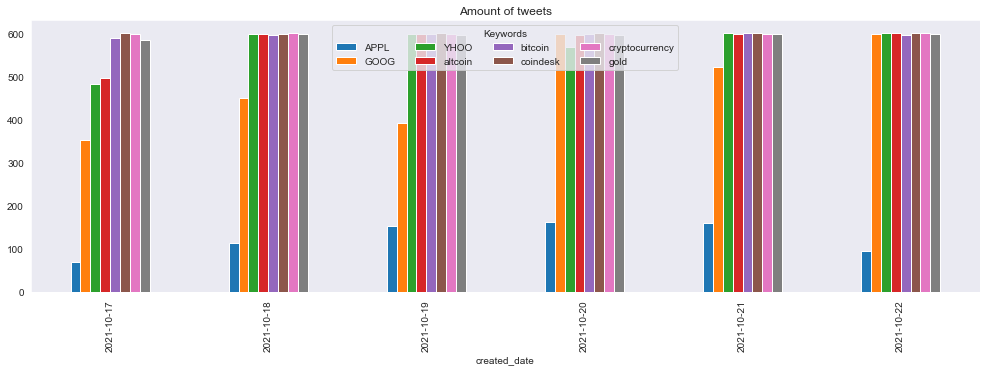

In [59]:
visualize_bars(table_per_tweets, 'Amount of tweets')

In [60]:
# This table contains the summary by amount of users per day and keyword
table_per_users

Keyword,APPL,GOOG,YHOO,altcoin,bitcoin,coindesk,cryptocurrency,gold
created_date,,,,,,,,
2021-10-17,52,284,402,376,485,415,464,561
2021-10-18,94,368,526,324,528,442,469,548
2021-10-19,115,311,487,499,511,534,427,565
2021-10-20,126,519,484,384,534,469,468,554
2021-10-21,124,428,488,358,540,514,454,534
2021-10-22,68,457,522,463,518,466,448,545


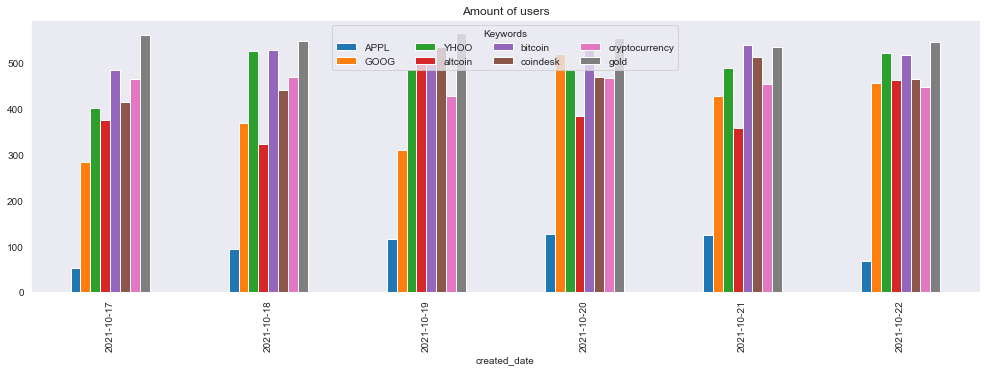

In [61]:
visualize_bars(table_per_users, 'Amount of users')